# Hackathon – Challenge 3: **Decentralized (No Central Server)**
**Goal:** Remove the central aggregator. Each round, only a subset of clients is active (as in Challenge 1),
performs local training (and optional P2P refinement), then **models are mixed via gossip** among active clients.

**Key knobs:**
- `ACTIVE_FRACTION` / `ACTIVE_CLIENTS`: who is active each round.
- `GOSSIP_TOPOLOGY`: `'random_neighbor'` (pairwise averaging) or `'all_active_avg'` (average all active).
- We evaluate **each node individually** and track per-node accuracies over time.



### FedP2PAvg vs. FedAvg 

This notebook provides a clean, **fully-commented** baseline to run either the **traditional FedAvg** or the **peer-to-peer (P2P) refinement** variant **FedP2PAvg** in **federated learning under non-IID Dirichlet partitions**.

The structure intentionally mirrors your function naming and flow so participants can quickly extend it during the hackathon:

- Toggle: `FAST_MODE` (speed vs determinism).
- Models: `NetMnist` (LeNet-like), `NetMnistFC`, `BasicBlock`, `NetCifar10` (VGG-11 like).
- Load dataset: `load_dataset(dataset, n_particoes, dirichlet_alpha)` — Dirichlet partition (sequential consumption, per-partition shuffle).
- Load networks and data Visualization:  `loadNetowrk`, `configure_nets`, `plot_class_distribution`.
- Training modes: `train_nets` (classic local training), `train_p2p` (p2p training step).
- Aggregation & evaluation: `combine`, `eval`,.
- Visualization: `plot_class_distribution`.
- **Main loop**


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import pickle
import os
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

# ---------- FAST_MODE toggle ----------
# When True: faster runs (cudnn benchmark on)
# When False: deterministic behavior for reproducibility
FAST_MODE = True

# ---------- Seeds & Determinism ----------
SEED = 2
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

if FAST_MODE:
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
else:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# Windows
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# MAC
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print(f"Usando o dispositivo: {DEVICE}")


Usando o dispositivo: mps


### Experiment Configuration (Quick Knobs for the Hackathon)

This cell centralizes the **main hyperparameters** and **experiment switches** you’ll tweak during the hackathon. Adjust these to compare **FedAvg** vs **FedP2PAvg**, datasets, and heterogeneity levels.

---

#### Run Mode & Dataset
- `RUN_MODE =`  
  Options: `"fedavg"` or `"fedp2pavg"`.  
  - **fedavg:** classic centralized non-weighted aggregation (baseline).  
  - **fedp2pavg:** adds **peer-to-peer refinement** between clients before global aggregation; often improves stability/accuracy under non-IID data at modest comms cost.
- `DATASET =`  
  Options: `"mnist"`, `"fashionmnist"`, `"cifar10"`.  
  - Use **MNIST/FashionMNIST** for faster iterations; **CIFAR-10** for a more challenging RGB benchmark.
- `NUM_CLASSES = 10`  
  Number of classes in the chosen dataset (MNIST/FashionMNIST/CIFAR-10 = 10).

---

#### Federated Setup
- `N_CLIENTS = 10`  
  Total simulated clients participating in training (per round, this can be all or a subset depending on your training loop).
- `DIRICHLET_ALPHA = 0.1`  
  Controls **non-IID p**


In [2]:
RUN_MODE = "fedavg"      # options: "fedavg" or "fedp2pavg"
DATASET  = "mnist"       # options: "mnist", "fashionmnist", "cifar10"
NUM_CLASSES = 10

N_CLIENTS = 10           # number of federated clients
DIRICHLET_ALPHA = 0.1    # lower => more heterogeneous

LOCAL_EPOCHS = 2         # local epochs per round
BATCH_SIZE   = 128
LR           = 0.01
MOMENTUM     = 0.9

GLOBAL_ROUNDS = 600       # keep modest for quick demo

# --- Challenge 3 knobs ---
ACTIVE_FRACTION = 0.5
ACTIVE_CLIENTS = None
GOSSIP_TOPOLOGY = 'all_active_avg'  # options: 'random_neighbor', 'all_active_avg'


### Neural Network Architectures for FL Experiments

This cell defines **four neural network building blocks** you can plug into your federated learning experiments, depending on the dataset and compute/communication budget on each client. All classes follow the standard PyTorch `nn.Module` pattern (`__init__` to declare layers, `forward` to define the data flow) and **return raw logits** (no softmax), which is what `nn.CrossEntropyLoss` expects.

---

#### `NetMnist` — lightweight CNN for MNIST (1×28×28)
- **Purpose:** A small, regularized convolutional model that works well on MNIST while keeping parameters/updates compact for FL.
- **Architecture flow:**
  1. `Conv2d(1→10, k=5)` → `MaxPool2d(2)` → `ReLU`
  2. `Conv2d(10→20, k=5)` → `Dropout2d` → `MaxPool2d(2)` → `ReLU`
  3. **Flatten** to 320 features (`20×4×4` from the conv stack)
  4. `Linear(320→50)` → `ReLU` → `Dropout`
  5. `Linear(50→10)` → **logits**
- **Shape trace (N=batch size):**
  - Input: `(N, 1, 28, 28)`
  - After `conv1`: `(N, 10, 24, 24)` → pool → `(N, 10, 12, 12)`
  - After `conv2`: `(N, 20, 8, 8)` → pool → `(N, 20, 4, 4)` → flatten → `(N, 320)`
  - FCs → `(N, 10)`
- **Notes:** `Dropout2d` regularizes feature maps; use this when clients are very resource-constrained but you still want conv features.

---

#### `NetMnistFC` — fully connected MNIST baseline
- **Purpose:** A tiny MLP baseline without convolutions; useful as a minimal communication/compute baseline or sanity check.
- **Architecture flow:**
  1. **Flatten** image from `(1, 28, 28)` to `784`
  2. `Linear(784→50)` → `ReLU`
  3. `Linear(50→10)` → **logits**
- **Shape trace:** `(N, 1, 28, 28)` → `(N, 784)` → `(N, 50)` → `(N, 10)`
- **Important fix:** In `__init__`, change `super(NetMnist, self).__init__()` to **`super(NetMnistFC, self).__init__()`** (or simply `super().__init__()`).

---

#### `BasicBlock` — ResNet-style residual block (for deeper backbones)
- **Purpose:** A standard two-conv residual block with optional projection shortcut; typical of ResNet-18/34 (expansion=1).
- **Architecture flow:**
  1. `Conv2d(in→out, 3×3, stride, padding=1, no bias)` → `BatchNorm2d` → `ReLU`
  2. `Conv2d(out→out, 3×3, stride=1, padding


In [3]:
class NetMnist(nn.Module):
    def __init__(self):
        super(NetMnist, self).__init__()
        # Layer 1
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)  # Conv1
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling
        # Layer 2
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)  # Conv2
        self.dropout2d = nn.Dropout2d()  # Dropout2d
        # Layer 3
        self.fc1 = nn.Linear(320, 50)  # FC1
        self.dropout = nn.Dropout()  # Dropout
        # Layer 4
        self.fc2 = nn.Linear(50, 10)  # FC2

    def forward(self, x):
        # Layer 1 operations
        x = self.conv1(x)
        x = self.pool(x)
        x = F.relu(x)
        # Layer 2 operations
        x = self.conv2(x)
        x = self.dropout2d(x)
        x = self.pool(x)
        x = F.relu(x)
        # Flatten
        x = x.view(-1, 320)  # Flatten the tensor
        # Layer 3 operations
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        # Layer 4 operation
        x = self.fc2(x)
        return x

class NetMnistFC(nn.Module):
    def __init__(self):
        super(NetMnist, self).__init__()
        # Input layer
        self.fc1 = nn.Linear(784, 50)  # Fully connected layer from 784 to 50 neurons
        # Hidden layer
        self.fc2 = nn.Linear(50, 10)   # Fully connected layer from 50 to 10 neurons

    def forward(self, x):
        # Flatten the image from (1, 28, 28) to (784)
        x = x.view(-1, 784)
        # Forward pass through the first fully connected layer and apply ReLU activation
        x = F.relu(self.fc1(x))
        # Forward pass through the second fully connected layer to produce output
        x = self.fc2(x)
        return x

class NetCifar10(nn.Module):
    """
    Compact CNN for CIFAR-10 tailored for Federated Learning:
    - GroupNorm instead of BatchNorm (robust under non-IID, small local batches)
    - 3 conv stages with MaxPool
    - Dropout2d for mild regularization
    - Global Average Pooling -> tiny classifier head
    """
    def __init__(self, num_classes=10, gn_groups=8, dropout_p=0.1):
        super().__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
                nn.GroupNorm(num_groups=min(gn_groups, out_ch), num_channels=out_ch),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=dropout_p)
            )

        # Stage 1: 32x32 -> 16x16
        self.stem = nn.Sequential(
            conv_block(3, 64),
            conv_block(64, 64),
            nn.MaxPool2d(2)
        )

        # Stage 2: 16x16 -> 8x8
        self.stage2 = nn.Sequential(
            conv_block(64, 128),
            conv_block(128, 128),
            nn.MaxPool2d(2)
        )

        # Stage 3: 8x8 -> 4x4
        self.stage3 = nn.Sequential(
            conv_block(128, 256),
            conv_block(256, 256),
            nn.MaxPool2d(2)
        )

        # Global Average Pooling -> (B, 256, 1, 1)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc  = nn.Linear(256, num_classes)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.stem(x)    # -> (B, 64, 16, 16)
        x = self.stage2(x)  # -> (B, 128, 8, 8)
        x = self.stage3(x)  # -> (B, 256, 4, 4)
        x = self.gap(x)     # -> (B, 256, 1, 1)
        x = torch.flatten(x, 1)  # -> (B, 256)
        x = self.fc(x)      # logits (B, num_classes)
        return x


### Loading and Partitioning the Dataset

This function `load_dataset` handles **three key tasks**:

1. **Download & preprocess datasets**  
   - Supports **MNIST**, **CIFAR-10**, and **Fashion-MNIST**.  
   - Applies dataset-specific **normalization** to scale pixel values into ranges suitable for training.  
   - Returns standard **PyTorch `Dataset`** objects and corresponding **`DataLoader`** wrappers:
     - `train_loader` → batches of training samples (size = `BATCH_SIZE`) shuffled each epoch  
     - `test_loader` → test set in large batches (size = 1000) for fast evaluation

2. **Partition training data among clients**  
   - Uses the **Dirichlet distribution** to split the training set indices into `n_particoes` subsets.  
   - This simulates **non-IID data** across clients:  
     - Each class’s samples are allocated unevenly to different clients.  
     - The concentration parameter `dirichlet_alpha` controls the level of imbalance:  
       - Small `α` → stronger heterogeneity (clients specialize in fewer classes).  
       - Large `α` → more balanced splits across clients.  

3. **Return datasets and partitions**  
   - `train_dataset`, `test_dataset` → full datasets  
   - `train_loader`, `test_loader` → DataLoaders for centralized training/evaluation  
   - `idx` → list of index arrays, one per client, specifying which samples belong to which partition  

---

#### Why this matters for Federated Learning
- Federated setups require each client to train on its **own subset of data**.  
- By using Dirichlet-based splits, the experiment simulates realistic **data heterogeneity** across participants.  
- This allows you to compare how different algorithms (e.g., **FedAvg** vs **FedP2PAvg**) cope with **non-IID and imbalanced** data distributions.  


In [ ]:
def load_dataset(dataset, n_particoes, dirichlet_alpha):
    train_dataset = None
    test_dataset = None
    train_loader = None
    test_loader = None
    idx = None
    if dataset == 'mnist':
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
        train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST('../data', train=False, transform=transform)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=1000)
    elif dataset == 'cifar10':
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465),
                                                        (0.2470, 0.2435, 0.2616))])
        train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=1000)
    elif dataset == 'fashionmnist':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=1000)

    if train_dataset:
        targets = np.array(train_dataset.targets)
        classes = np.unique(targets)

        idx = [[] for _ in range(n_particoes)]

        for c in classes:
            # class c indexes
            indexes = np.where(targets == c)[0]
            np.random.shuffle(indexes)

            # Dirichlet proportions and initial integer counts
            props = np.random.dirichlet([dirichlet_alpha] * n_particoes)
            raw = props * len(indexes)
            counts = raw.astype(int)

            # redistributes the "remainder" to add up to exactly len(indexes)
            deficit = len(indexes) - counts.sum()
            if deficit > 0:
                # gives the remainders to the largest fractional parts
                fracs = raw - counts
                order = np.argsort(-fracs)
                for k in range(deficit):
                    counts[order[k % n_particoes]] += 1

            # slice and add
            start = 0
            for i, p in enumerate(counts):
                if p > 0:
                    idx[i].extend(indexes[start:start + p].tolist())
                    start += p

        # shuffles each partition
        idx = [np.random.permutation(x).tolist() for x in idx]

        # ensures no partition is empty (moves 1 sample from the largest "donor")
        sizes = [len(x) for x in idx]
        empties = [i for i, s in enumerate(sizes) if s == 0]
        for e in empties:
            donor = int(np.argmax(sizes))
            if sizes[donor] > 1:
                idx[e].append(idx[donor].pop())
                sizes[donor] -= 1
                sizes[e] += 1


    return train_dataset, test_dataset, train_loader, test_loader, idx

### Model Factory + Client Initialization + Non-IID Split Visualization

This cell provides three utilities you’ll reuse across experiments:

1) **`loadNetwork(dataset, device)` — pick a backbone per dataset**  
   - For `"mnist"` and `"fashionmnist"`, returns `NetMnist()`; for `"cifar10"`, returns `NetCifar10()`.  
   - Moves the model to the specified `device` (e.g., `"cuda"` or `"cpu"`).  
   - **Tip:** If you want to compare backbones, extend this to accept a `model_name` (e.g., `"cnn"`, `"mlp"`, `"vgg11"`) and route accordingly (you already have `NetMnistFC` available but not used here).

2) **`configure_nets(dataset, n_clients, device)` — instantiate per-client models**  
   - Builds a list of `n_clients` and a `net_central_node` **independent model instances** using `loadNetwork`.  
   - In federated training, each client holds its own model copy; server aggregation will combine weights later.  
   - **Note:** If you plan to do partial participation per round, you can still pre-create all clients once here.

3) **`plot_class_distribution(idx, train_dataset, num_classes)` — sanity-check the Dirichlet split**  
   - Expects `idx` to be a list of index lists (one per client/partition) from your Dirichlet partitioner.  
   - Extracts labels from `train_dataset.targets` (works with both **`torch.Tensor`** and **Python lists**).  
   - Computes per-class counts per partition, then renders a **stacked bar chart** so you can visually verify non-IID skew.  
   - Legend shows **Class 0..(num_classes−1)**; x-axis lists partitions; y-axis shows sample counts.

---

#### Why this matters
- **Model allocation:** Each client must have a model instance to perform local updates before aggregation.  
- **Correctness check for splits:** Visual confirmation helps catch mistakes like empty partitions, extreme imbalance beyond your chosen `DIRICHLET_ALPHA`, or mislabeled targets.




In [ ]:
def loadNetwork(dataset, device):
    net = None
    if dataset == 'mnist' or dataset == 'fashionmnist':
        net = NetMnist().to(device)
    elif dataset == 'cifar10':
        net = NetCifar10().to(device)
    return net

def configure_nets(dataset, n_clients, device):
    net_central_node = loadNetwork(dataset, device)
    nets = []
    for i in range(n_clients):
        nets.append(loadNetwork(dataset, device))
    return nets, net_central_node

def plot_class_distribution(idx, train_dataset, num_classes):
    """
    Plots a bar chart showing the class distribution across partitions.

    Args:
        idx (list of lists): Indices of the partitions.
        train_dataset (Dataset): Dataset containing the labels.
        num_classes (int): Number of classes (default: 10 for MNIST).
    """
    # Calculate the class distribution for each partition
    class_distributions = []
    for partition_indices in idx:
        part_targets = None
        if isinstance(train_dataset.targets, torch.Tensor):
            part_targets = [train_dataset.targets[index].item() for index in partition_indices]
        else:
            part_targets = [train_dataset.targets[index] for index in partition_indices]
        class_counts = [part_targets.count(class_label) for class_label in range(num_classes)]
        class_distributions.append(class_counts)

    # Convert to numpy for easier handling
    class_distributions = np.array(class_distributions)

    # Configure the chart
    num_partitions = len(idx)
    partition_indices = range(num_partitions)
    bar_width = 0.8

    # Colors for each class
    colors = plt.cm.tab10(np.linspace(0, 1, num_classes))

    # Create stacked bars
    fig, ax = plt.subplots(figsize=(14, 7))
    bottom_values = np.zeros(num_partitions)
    for class_idx in range(num_classes):
        ax.bar(
            partition_indices,
            class_distributions[:, class_idx],
            bottom=bottom_values,
            color=colors[class_idx],
            label=f'Class {class_idx}',
            width=bar_width
        )
        bottom_values += class_distributions[:, class_idx]

    # Chart configurations
    ax.set_xlabel('Partition', fontsize=14)
    ax.set_ylabel('Number of Samples', fontsize=14)
    ax.set_title('Class Distribution Across Partitions', fontsize=16)
    ax.set_xticks(partition_indices)
    ax.set_xticklabels([f'Partition {i}' for i in partition_indices], rotation=45)
    ax.legend(title='Classes', fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


### Local Training Loops: Independent vs. P2P Refinement

This cell defines **two training routines** used by the hackathon baselines: a standard **per-client local training** loop and a minimal **peer-to-peer (P2P) refinement** loop. Both operate on **non-IID partitions** produced earlier and use **SGD + CrossEntropyLoss**.

---

#### `train_nets(nets, n_epochs, train_dataset, idx, device)`
- **What it does:** Trains **each client’s own model** `nets[i]` on that client’s data partition `idx[i]` for `n_epochs`.  
- **Data loader:** `DataLoader(Subset(train_dataset, idx[i]), batch_size=BATCH_SIZE, shuffle=True)` ensures each client only sees its assigned samples, shuffled every epoch.  
- **Optimization:** For each client, creates a fresh `optimizer = optim.SGD(..., lr=LR, momentum=MOMENTUM)` and a `criterion = nn.CrossEntropyLoss()`.  
- **Loop structure:**  
  - Outer loop over clients.  
  - Inner loop over `epoch` and mini-batches: forward → loss → backward → step.  
- **Device:** Moves batches to `device` for GPU/CPU execution.  
- **Returns:** The list `nets` with locally updated weights.

---

#### `train_p2p(nets, n_clients, n_epochs, train_dataset, idx, device)`
- **What it does (current behavior):** For each partition `i`, **select a random peer `j`** and train **that peer’s model `nets[j]`** on partition `i`’s data for `n_epochs`. This mimics a simple P2P refinement step where models **learn from other clients’ distributions** before global aggregation.
- **Peer selection:** `j = np.random.choice(range(n_clients))` → **uniform random** peer per partition.  
- **Data loader:** Same construction as above but always using `idx[i]` (the data of the “source” client).  
- **Optimization:** Fresh SGD and CE loss for the selected peer `nets[j]`.  
- **Returns:** The list `nets` after all random peer refinements.

**Important behavioral implications**
- Because `j` is random, **some clients may be updated multiple times** in a pass, while others may not be updated at all.  
- A client’s **own model `nets[i]` is not guaranteed** to be trained on `idx[i]` in this routine (only if `j == i`). This is intentional for P2P mixing, but keep it in mind when analyzing convergence.  

---

#### Good practices & suggested improvements (optional)
- **Optimizer state:** In P2P, re-creating the optimizer per mini-refinement **drops momentum history**. If you want momentum to carry over across multiple P2P updates of the **same** model within a round, keep a **dict of optimizers** keyed by client id.  
- **Balance updates:** To ensure every peer is refined at least once, sample a **derangement/matching** or a **fixed number of updates per target peer** instead of i.i.d. random picks.  
- **Criteria-based pairing:** Replace random `j` with a **selection policy** (e.g., topology neighbors, cosine similarity of weights/gradients, loss-based, or availability).  


In [6]:
def train_nets(nets, n_epochs, train_dataset, idx, device):
    for i, net in enumerate(nets):
        optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM)
        criterion = nn.CrossEntropyLoss()
        part_loader = DataLoader(Subset(train_dataset, idx[i]), batch_size=BATCH_SIZE, shuffle=True)
        for epoch in range(1, n_epochs):
            net.train()
            for batch_idx, (data, target) in enumerate(part_loader):
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = net(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
    return nets



def train_p2p(nets, n_clients, n_epochs, train_dataset, idx, device):
    for i in range(n_clients):
        part_loader = DataLoader(Subset(train_dataset, idx[i]), batch_size=BATCH_SIZE, shuffle=True)
        j = np.random.choice(range(n_clients))
        net = nets[j]
        optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM)
        criterion = nn.CrossEntropyLoss()
        for epoch in range(n_epochs):
            net.train()
            for batch_idx, (data, target) in enumerate(part_loader):
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = net(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
    return nets

### Server-Side Aggregation (`combine`) and Centralized Evaluation (`eval`)

This cell implements two standard server operations for federated learning:

1) **`combine(nets, net_central_node)` — FedAvg-style aggregation + broadcast**  
   - **Goal:** Average client model parameters to form a global model, copy the average into `net_central_node`, and then **broadcast** the global weights back to clients.  
   - **Steps:**  
     1. Create `average_weights` with the same shapes as the first client’s parameters.  
     2. Accumulate parameters from all clients into `average_weights`.  
     3. Divide by the number of clients to compute the mean.  
     4. Copy the averaged weights into `net_central_node`.  
     5. **Broadcast**: copy the global weights back to each client model so every client starts the next round from the same initialization.  

2) **`eval(net_eval, test_loader, device)` — centralized test evaluation**  
   - **Goal:** Compute average loss and accuracy of a given model on the test set.  
   - **Details:**  
     - Sets the model to `eval()` and disables gradients with `torch.no_grad()`.  
     - Loops over the test loader, accumulates total loss, and counts correct predictions via `argmax`.  
     - Prints and returns accuracy (in %).  
---


In [7]:
def combine(nets, net_central_node):
    with torch.no_grad():
        average_weights = [torch.zeros_like(p) for p in net_central_node.parameters()]
        for net in nets:
            for avg_p, p in zip(average_weights, net.parameters()):
                avg_p.add_(p.data)
        for avg_p in average_weights:
            avg_p.div_(len(nets))
        for p, avg_p in zip(net_central_node.parameters(), average_weights):
            p.data.copy_(avg_p)
        for net in nets:
            for p, p_node in zip(net.parameters(), net_central_node.parameters()):
                p.data.copy_(p_node.data)
            for buffer, buffer_node in zip(net.buffers(), net_central_node.buffers()):
                buffer.copy_(buffer_node)
    return nets, net_central_node

def eval(net_eval, test_loader, device):
    criterion = nn.CrossEntropyLoss()
    net_eval.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = net_eval(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    #print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    #    test_loss, correct, len(test_loader.dataset),
    #    100. * correct / len(test_loader.dataset)))
    return 100.0 * correct / len(test_loader.dataset)

In [8]:

def gossip_round(nets, active_ids, topology='random_neighbor'):
    """
    Perform a single gossip mixing step among active clients.
    topology:
      - 'random_neighbor': randomly pair active clients; each pair averages weights pairwise.
      - 'all_active_avg': average all active models and assign back to active clients.
    """
    import random
    ids = list(active_ids)
    if len(ids) <= 1:
        return nets  # nothing to mix
    
    if topology == 'all_active_avg':
        with torch.no_grad():
            # compute avg over active
            ref = nets[ids[0]]
            avg_params = [torch.zeros_like(p) for p in ref.parameters()]
            for i in ids:
                for ap, p in zip(avg_params, nets[i].parameters()):
                    ap.add_(p.data)
            for ap in avg_params:
                ap.div_(len(ids))
            # assign back to active clients
            for i in ids:
                for p, ap in zip(nets[i].parameters(), avg_params):
                    p.data.copy_(ap)
        return nets
    
    # default: random_neighbor (pairwise average)
    random.shuffle(ids)
    # if odd, leave last one unchanged this round
    pairs = list(zip(ids[0::2], ids[1::2])) if len(ids) > 1 else []
    with torch.no_grad():
        for a,b in pairs:
            for pa, pb in zip(nets[a].parameters(), nets[b].parameters()):
                tmp = (pa.data + pb.data) / 2.0
                pa.data.copy_(tmp)
                pb.data.copy_(tmp)
    return nets


### Dataset Preparation & Partition Visualization

This cell loads the selected dataset, splits it into federated client partitions using a **Dirichlet distribution**, and then visualizes the resulting class distributions across clients. Specifically:

- **`load_dataset(DATASET, N_CLIENTS, DIRICHLET_ALPHA)`**  
  - Downloads and normalizes the chosen dataset (`"mnist"`, `"fashionmnist"`, `"cifar10"`).  
  - Returns:
    - `train_dataset`, `test_dataset` → full PyTorch dataset objects.  
    - `train_loader`, `test_loader` → DataLoaders for centralized evaluation/debugging.  
    - `idx` → list of index arrays, one per client, assigning samples to clients.  
  - The `DIRICHLET_ALPHA` parameter controls **data heterogeneity**:  
    - Smaller values (e.g., 0.05–0.1) → highly skewed partitions (non-IID).  
    - Larger values (e.g., 0.5–10) → more balanced, closer to IID.

- **`plot_class_distribution(idx, train_dataset, NUM_CLASSES)`**  
  - Renders a stacked bar chart where each bar corresponds to one client partition.  
  - Colors indicate per-class sample counts inside each client.  
  - Useful to verify that the data split behaves as expected under the chosen Dirichlet α.

**Why this step matters:** It ensures that each federated client trains only on its allocated data, while letting you *visualize the non-IID effect*—a key challenge for federated optimization algorithms like FedAvg and FedP2PAvg.


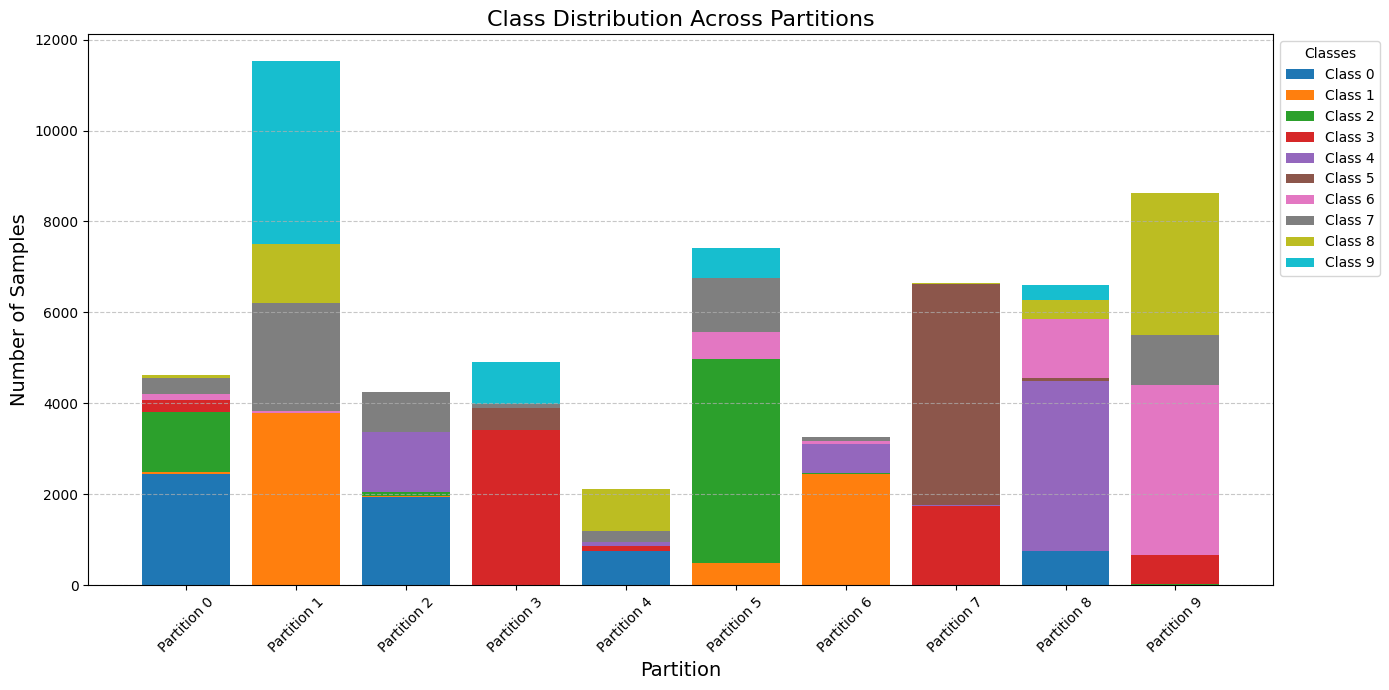

In [9]:
train_dataset, test_dataset, train_loader, test_loader, idx = load_dataset(DATASET, N_CLIENTS, DIRICHLET_ALPHA)

plot_class_distribution(idx, train_dataset, NUM_CLASSES)

### Federated Training Loop: Local Updates → (Optional) P2P Refinement → FedAvg Combine → Central Eval

This cell runs the **end-to-end federated training process** over `GLOBAL_ROUNDS`. Each round performs:
1) **Local client training** on each client’s own partition (`train_nets`),  
2) **(Optional) P2P refinement** where models learn from other clients’ distributions (`train_p2p` when `RUN_MODE == "fedp2pavg"`),  
3) **Server-side aggregation + broadcast** (`combine`) to produce a new global model, and  
4) **Centralized evaluation** of the global model on the test set (`eval`), logging accuracy over time.

**Step-by-step**
- `nets, central_node = configure_nets(DATASET, N_CLIENTS, DEVICE)`  
  Initializes client models and the central/global model reference.  
  > **Note:** Ensure `configure_nets` returns both `(nets, central_node)` or create `central_node = loadNetwork(DATASET, DEVICE)` separately if it currently returns only `nets`.

- `for i in range(1, GLOBAL_ROUNDS):`  
  Iterates training **rounds**. (Starts at 1; if you prefer the full count, use `range(GLOBAL_ROUNDS)`.)

- `nets = train_nets(...)`  
  Each client trains **locally** on its own data subset for `LOCAL_EPOCHS`.

- `if RUN_MODE == "fedp2pavg": nets = train_p2p(...)`  
  Optional **peer-to-peer** step: randomly selected peers are further trained on other partitions’ data to reduce drift and improve stability under **non-IID** splits.

- `nets, central_node = combine(nets, central_node)`  
  **FedAvg-style aggregation**: average client parameters into `central_node`, then **broadcast** the global weights back to all clients so they start the next round from the same state.

- `accuracy = eval(central_node, test_loader, DEVICE)` → `accs.append(accuracy)`  
  Centralized test-time evaluation of the global model; accuracy is recorded each round to `accs` for plotting/analysis.

- Final `eval(central_node, test_loader, DEVICE)` and `print(accs)`  
  Prints the last evaluation and the **accuracy trajectory** across rounds.


In [10]:
# Decentralized main loop (no central server)
nets, central_node = configure_nets(DATASET, N_CLIENTS, DEVICE)
# Ignore central_node in decentralized mode
central_node = None

accs = []
for i in range(1, GLOBAL_ROUNDS):
    print(f"Epoch: {i}")
    if ACTIVE_CLIENTS is not None:
        k = int(ACTIVE_CLIENTS)
    else:
        k = max(1, int(ACTIVE_FRACTION * N_CLIENTS))
    active_ids = np.random.choice(np.arange(N_CLIENTS), size=k, replace=False)
    print(f"Active clients this round: {sorted(list(active_ids))}")

    nets = train_nets(nets, LOCAL_EPOCHS, train_dataset, idx, DEVICE)
    if RUN_MODE == "fedp2pavg":
        print("Starting p2p step")
        nets = train_p2p(nets, N_CLIENTS, LOCAL_EPOCHS, train_dataset, idx, DEVICE)
    print("Gossip mixing")
    nets = gossip_round(nets, active_ids, topology=GOSSIP_TOPOLOGY)
    # Per-node evaluation
    acc_vec = []
    for i_node in range(N_CLIENTS):
        acc_vec.append(eval(nets[i_node], test_loader, DEVICE))
    print(f"Accuracies this round: {acc_vec}")
    accs.append(acc_vec)

print(accs)


Epoch: 1
Active clients this round: [3, 4, 7, 8, 9]
Gossip mixing
Accuracies this round: [24.33, 38.27, 27.63, 10.1, 10.1, 35.44, 18.35, 10.1, 10.1, 10.1]
Epoch: 2
Active clients this round: [1, 2, 3, 5, 9]
Gossip mixing
Accuracies this round: [38.96, 11.29, 11.29, 11.29, 9.8, 11.29, 20.57, 15.94, 24.41, 11.29]
Epoch: 3
Active clients this round: [0, 1, 4, 7, 9]
Gossip mixing
Accuracies this round: [31.75, 31.75, 29.04, 19.33, 31.75, 42.51, 20.78, 31.75, 38.54, 31.75]
Epoch: 4
Active clients this round: [0, 2, 3, 4, 6]
Gossip mixing
Accuracies this round: [30.98, 39.4, 30.98, 30.98, 30.98, 49.38, 30.98, 18.37, 42.29, 34.87]
Epoch: 5
Active clients this round: [0, 1, 3, 4, 6]
Gossip mixing


KeyboardInterrupt: 